## The Zimnat Insurance Assurance Challenge
This is a zindi hackatons competition  which you can see following this link https://zindi.africa/hackathons/the-zimnat-insurance-assurance-challenge
<p> In this hackathon our objective is to develop a predictive model that determines the likelihood for an insurance customer to churn - to seek an alternative insurer or simply drop out of the insurance market altogether. In light of the current pandemic, churn prediction can be used to offer targeted support and tailored services to certain customers vulnerable to churning. This means more people can continue to be covered when they most need it most and insurance companies can be more efficient at serving and retaining their customers. </p>

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from collections import Counter

warnings.filterwarnings("ignore")
warnings.simplefilter(action= 'ignore', category= FutureWarning)
pd.set_option('display.max_columns', 200)

SEED = 10

random.seed(SEED)
np.random.seed(SEED)

## Client_data
Contains some personal information on the principal member, such as location, branch and agent code, age etc. 
* Policy_ID - Policy ID for the main member
* NPH_LASTNAME - last name of principle member
* NPH_SEX - sex of principle member
* NPH_BIRTHDATE - birth year of principle member
* NAD_ADDRESS1 - main address of principle member
* NAD_ADDRESS2 - second address of principle member 
 
## Payment_history
Contains partial payment history up to the end of 2018, tied to Policy ID. 
* Policy_ID - Policy ID for the main member
* AMOUNTPAID - Amount paid
* DATEPAID - date payment made
* POSTDATE - a cool functionality to have for disussions is for Zindi to be able to pin posts to the top of challenge threads.
* PREMIUMDATE - it states the next date on which the premium should be paid by to keep the policy alive

## Policy_data.csv
Describes the policies themselves. There may be multiple rows for each Policy ID since policies can cover more than one person.
* Policy_ID - Policy ID for the main member
* NP2_EFFECTDATE - Date started
* PPR_PRODCD - specifies the product code of product subscribed by the client
* NPR_PREMUIM - Extra premium
* NPH_LASTNAME - last name of member
* CLF_LIFECD - differentiates relationship to principal.   1 principal 2 spouse , 3 child , 4 parent , 5 parent, 6 extended
* NSP_SUBPROPOSAL - unique identifier of a life on a policy on a specific policy we can have the principal as 111  child1 as 222 child2 as 333
* NPR_SUMASSURE - 
* NLO_TYPE - identifies the premium types charged on a policy
* NLO_AMOUNT - amount if there’s an extra charge
* AAG_AGCODE - agent code of the policy agent
* PCL_LOCATCODE - branch code
* OCCUPATION - Job 
* CATEGORY - area of work

## train.csv 
Contains a list of all the policies. Policies that lapsed in 2017, 2018 or 2019 are identified with a 1 in the ‘Lapse’ column, and the year is provided. All other columns have a ‘?’ you need to predict if that customer will lapse in 2020. 
* Policy_ID 
* Lapse
* Lapse Year

## load data
* client_data

In [2]:
client_data = pd.read_csv('data/client_data.csv')

print(client_data.shape)
client_data.head(3)

(147462, 7)


,Policy ID,NPH_TITLE,NPH_LASTNAME,NPH_SEX,NPH_BIRTHDATE,NAD_ADDRESS1,NAD_ADDRESS2
0,PID_P1UHZRT,Ms.,NaN,F,1997,ADDRESS1_WSRXQ43,ADDRESS2_AIIHWOT
1,PID_GUI5GQJ,Mr.,NPH_LASTNAME_L256UFJ,M,1954,ADDRESS1_WSRXQ43,ADDRESS2_AIIHWOT
2,PID_LECMECN,Mr.,NPH_LASTNAME_3YMQL4X,M,1923,ADDRESS1_WSRXQ43,ADDRESS2_AIIHWOT


In [3]:
client_data.isnull().sum()

Policy ID            0
NPH_TITLE            0
NPH_LASTNAME     32646
NPH_SEX              0
NPH_BIRTHDATE        0
NAD_ADDRESS1     49038
NAD_ADDRESS2     47129
dtype: int64

In [4]:
client_data['Policy ID'].nunique()

31392

* payment_history

In [5]:
payment_history = pd.read_csv('data/payment_history.csv')

print(payment_history.shape)
payment_history.head(3)

(495503, 5)


,Policy ID,AMOUNTPAID,DATEPAID,POSTDATE,PREMIUMDUEDATE
0,PID_VTBGKIZ,1287.423813,2018-12-29 00:00:00,2018-12-29 00:00:00,2018-01-11 00:00:00
1,PID_9J9V5YQ,0.000000,2017-04-10 00:00:00,2017-04-10 17:30:00,2017-01-10 00:00:00
2,PID_RT2SI59,3435.950888,2018-12-24 00:00:00,2018-12-28 00:00:00,2019-01-01 00:00:00


In [6]:
payment_history = payment_history.sort_values(['Policy ID', 'DATEPAID'])

* policy_data

In [7]:
policy_data = pd.read_csv('data/policy_data.csv')

print(policy_data.shape)
policy_data.head(3)

(282815, 14)


,Policy ID,NP2_EFFECTDATE,PPR_PRODCD,NPR_PREMIUM,NPH_LASTNAME,CLF_LIFECD,NSP_SUBPROPOSAL,NPR_SUMASSURED,NLO_TYPE,NLO_AMOUNT,AAG_AGCODE,PCL_LOCATCODE,OCCUPATION,CATEGORY
0,PID_EPZDSP8,1/9/2019,PPR_PRODCD_B2KVCE7,265.724174,NPH_LASTNAME_BPN2LEB,2,222,NaN,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_APWOOPE,PCL_LOCATCODE_7SHK7I9,OCCUPATION_NNHJ7XV,CATEGORY_GWW4FYB
1,PID_6M6G9IB,1/8/2018,PPR_PRODCD_64QNIHM,2795.069380,NPH_LASTNAME_U2H3GC6,1,111,213380.713197,NLO_TYPE_XTHV3A3,609.054794,AAG_AGCODE_9Z3FBGA,PCL_LOCATCODE_7VFS3EQ,OCCUPATION_IKCIDKW,CATEGORY_R821UZV
2,PID_UL0F7LH,1/8/2017,PPR_PRODCD_KOFUYNN,2492.759107,NPH_LASTNAME_B68RERV,1,111,238857.872515,NLO_TYPE_XAJI0Y6,1339.461987,AAG_AGCODE_Y0LKFF0,PCL_LOCATCODE_SKPRCR4,OCCUPATION_NUJZA7T,CATEGORY_8DALFYO


In [8]:
policy_data = policy_data.sort_values(['Policy ID', 'NP2_EFFECTDATE'])

In [9]:
policy_data.head(3)

,Policy ID,NP2_EFFECTDATE,PPR_PRODCD,NPR_PREMIUM,NPH_LASTNAME,CLF_LIFECD,NSP_SUBPROPOSAL,NPR_SUMASSURED,NLO_TYPE,NLO_AMOUNT,AAG_AGCODE,PCL_LOCATCODE,OCCUPATION,CATEGORY
73140,PID_000OJE4,1/3/2019,PPR_PRODCD_B2KVCE7,265.724174,NPH_LASTNAME_I3PY2YL,1,111,NaN,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_A753LC5,CATEGORY_GWW4FYB
78769,PID_000OJE4,1/3/2019,PPR_PRODCD_KOFUYNN,820.226234,NPH_LASTNAME_OR9F5IV,4,444,45513.429325,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_NNHJ7XV,CATEGORY_GWW4FYB
110254,PID_000OJE4,1/3/2019,PPR_PRODCD_KOFUYNN,217.975890,NPH_LASTNAME_I3PY2YL,3,333,45513.429325,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_NNHJ7XV,CATEGORY_GWW4FYB


* train

In [10]:
train = pd.read_csv('data/train.csv')

print(train.shape)
train.head(3)

(51685, 3)


,Policy ID,Lapse,Lapse Year
0,PID_4928TWH,?,?
1,PID_KBLLEGK,?,?
2,PID_90F0QA3,?,?


* sample_sub

In [11]:
sample_sub = pd.read_csv('data/sample_sub.csv')

print(sample_sub.shape)
sample_sub.head(3)

(43707, 2)


,Policy ID,Lapse
0,PID_4928TWH,0
1,PID_KBLLEGK,0
2,PID_90F0QA3,0


## Several function

In [12]:
def concat_fn(x):
    
    x = ','.join(x)
    
    return x

def max_count(x):
    
    x = concat_fn(x)
    
    x = x.split(',')
    
    res = Counter(x).most_common()[0][0]
    
    return res

## Grouped client_data

In [13]:
print(client_data.shape, client_data['Policy ID'].nunique())
client_data.head(3)

(147462, 7) 31392


,Policy ID,NPH_TITLE,NPH_LASTNAME,NPH_SEX,NPH_BIRTHDATE,NAD_ADDRESS1,NAD_ADDRESS2
0,PID_P1UHZRT,Ms.,NaN,F,1997,ADDRESS1_WSRXQ43,ADDRESS2_AIIHWOT
1,PID_GUI5GQJ,Mr.,NPH_LASTNAME_L256UFJ,M,1954,ADDRESS1_WSRXQ43,ADDRESS2_AIIHWOT
2,PID_LECMECN,Mr.,NPH_LASTNAME_3YMQL4X,M,1923,ADDRESS1_WSRXQ43,ADDRESS2_AIIHWOT


In [14]:
client_data['AGE'] = 2020 - client_data['NPH_BIRTHDATE'].astype(int)

In [15]:
client_grouped = client_data.groupby('Policy ID').agg({'AGE': 'mean'}).reset_index()
client_grouped.head(3)

,Policy ID,AGE
0,PID_000OJE4,37.5
1,PID_000YE7B,18.0
2,PID_002B54Z,39.0


## Grouped payment_history

In [16]:
print(payment_history.shape, payment_history['Policy ID'].nunique())
payment_history.head(3)

(495503, 5) 32223


,Policy ID,AMOUNTPAID,DATEPAID,POSTDATE,PREMIUMDUEDATE
425903,PID_0084LXN,3168.701768,2018-03-16 00:00:00,2018-03-27 00:00:00,2018-01-03 00:00:00
259142,PID_0084LXN,0.000000,2018-04-04 00:00:00,2018-04-04 00:00:00,2018-01-03 00:00:00
38223,PID_0084LXN,3168.701768,2018-05-31 00:00:00,2018-04-06 00:00:00,2018-01-05 00:00:00


In [17]:
payment_history['DATEPAID'] = pd.to_datetime(payment_history['DATEPAID'])
payment_history['PREMIUMDUEDATE'] = pd.to_datetime(payment_history['PREMIUMDUEDATE'])
payment_history['POSTDATE'] = pd.to_datetime(payment_history['POSTDATE'])

In [18]:
payment_history.isnull().sum()

Policy ID            0
AMOUNTPAID        3174
DATEPAID             0
POSTDATE             0
PREMIUMDUEDATE    5250
dtype: int64

In [19]:
payment_grouped = payment_history.groupby('Policy ID').agg(
                                        { 'AMOUNTPAID': ['mean', 'median', 'std', 'var', 'max', 'sum'],
                                          'DATEPAID': ['min', 'max', 'count'],
                                          'PREMIUMDUEDATE': ['min', 'max']
                                        }).reset_index()

In [20]:
payment_grouped.columns = ['Policy ID', 'AMOUNTPAID_mean', 'AMOUNTPAID_med', 'AMOUNTPAID_std', 'AMOUNTPAID_var', 
                           'AMOUNTPAID_max', 'AMOUNTPAID_sum', 'DATEPAID_min', 'DATEPAID_max', 'Policy_member_count',
                           'PREMIUMDUEDATE_min', 'PREMIUMDUEDATE_max']

In [21]:
payment_grouped.head(2)

,Policy ID,AMOUNTPAID_mean,AMOUNTPAID_med,AMOUNTPAID_std,AMOUNTPAID_var,AMOUNTPAID_max,AMOUNTPAID_sum,DATEPAID_min,DATEPAID_max,Policy_member_count,PREMIUMDUEDATE_min,PREMIUMDUEDATE_max
0,PID_0084LXN,2640.584806,3168.701768,1293.617080,1.673445e+06,3168.701768,15843.508838,2018-03-16,2018-11-04,6,2018-01-03,2018-01-07
1,PID_0098YXF,259.329045,259.329045,264.464772,6.994162e+04,518.658090,6742.555174,2017-12-21,2018-12-29,26,2017-01-12,2018-01-12


In [22]:
payment_grouped.isnull().sum()

Policy ID                 0
AMOUNTPAID_mean           0
AMOUNTPAID_med            0
AMOUNTPAID_std         1121
AMOUNTPAID_var         1121
AMOUNTPAID_max            0
AMOUNTPAID_sum            0
DATEPAID_min              0
DATEPAID_max              0
Policy_member_count       0
PREMIUMDUEDATE_min       14
PREMIUMDUEDATE_max       14
dtype: int64

## Grouped policy_data

In [23]:
print(policy_data.shape, policy_data['Policy ID'].nunique())
policy_data.head(3)

(282815, 14) 51685


,Policy ID,NP2_EFFECTDATE,PPR_PRODCD,NPR_PREMIUM,NPH_LASTNAME,CLF_LIFECD,NSP_SUBPROPOSAL,NPR_SUMASSURED,NLO_TYPE,NLO_AMOUNT,AAG_AGCODE,PCL_LOCATCODE,OCCUPATION,CATEGORY
73140,PID_000OJE4,1/3/2019,PPR_PRODCD_B2KVCE7,265.724174,NPH_LASTNAME_I3PY2YL,1,111,NaN,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_A753LC5,CATEGORY_GWW4FYB
78769,PID_000OJE4,1/3/2019,PPR_PRODCD_KOFUYNN,820.226234,NPH_LASTNAME_OR9F5IV,4,444,45513.429325,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_NNHJ7XV,CATEGORY_GWW4FYB
110254,PID_000OJE4,1/3/2019,PPR_PRODCD_KOFUYNN,217.975890,NPH_LASTNAME_I3PY2YL,3,333,45513.429325,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_NNHJ7XV,CATEGORY_GWW4FYB


In [24]:
policy_data['CLF_LIFECD'] = policy_data['CLF_LIFECD'].astype(str)
policy_data['NSP_SUBPROPOSAL'] = policy_data['NSP_SUBPROPOSAL'].astype(str)

In [25]:
policy_data['NP2_EFFECTDATE'] = pd.to_datetime(policy_data['NP2_EFFECTDATE'])

* Training

In [26]:
training = policy_data.loc[policy_data['NP2_EFFECTDATE']<'2020-01-01']

In [27]:
policy_grouped_training = training.groupby('Policy ID').agg({
                                                      'NP2_EFFECTDATE': ['min', 'max'],
                                                      'PPR_PRODCD': max_count,
                                                      'NPR_PREMIUM': ['mean', 'median', 'min', 'max', 'sum'],
                                                      'CLF_LIFECD': max_count,
                                                      'NSP_SUBPROPOSAL': max_count,
                                                      'NPR_SUMASSURED': ['mean', 'median', 'min', 'max', 'sum'],
                                                      'NLO_TYPE': max_count,
                                                      'NLO_AMOUNT': ['mean', 'median', 'min', 'max', 'sum'],
                                                      'AAG_AGCODE': max_count,
                                                      'PCL_LOCATCODE': max_count,
                                                      'OCCUPATION': max_count,
                                                      'CATEGORY': max_count
    
                                                      }).reset_index()

In [28]:
policy_grouped_training.columns = ['Policy ID', 'EFFECTDATE_min', 'EFFECTDATE_max', 'PPR_PRODCD', 'PREMIUM_mean',
                          'PREMIUM_med', 'PREMIUM_min', 'PREMIUM_max', 'PREMIUM_sum', 'CLF_LIFECD',
                          'NSP_SUBPROPOSAL', 'SUMASSURED_mean', 'SUMASSURED_med', 'SUMASSURED_min',
                          'SUMASSURED_max', 'SUMASSURED_sum', 'NLO_TYPE', 'NLO_AMOUNT_mean',
                          'NLO_AMOUNT_med', 'NLO_AMOUNT_min', 'NLO_AMOUNT_max', 'NLO_AMOUNT_sum',
                          'AAG_AGCODE', 'PCL_LOCATCODE', 'OCCUPATION', 'CATEGORY']

In [29]:
policy_grouped_training['PPR_PRODCD'] = policy_grouped_training['PPR_PRODCD'].factorize()[0]
policy_grouped_training['CLF_LIFECD'] = policy_grouped_training['CLF_LIFECD'].factorize()[0]
policy_grouped_training['NSP_SUBPROPOSAL'] = policy_grouped_training['NSP_SUBPROPOSAL'].factorize()[0]
policy_grouped_training['NSP_SUBPROPOSAL'] = policy_grouped_training['NSP_SUBPROPOSAL'].factorize()[0]
policy_grouped_training['NLO_TYPE'] = policy_grouped_training['NLO_TYPE'].factorize()[0]
policy_grouped_training['AAG_AGCODE'] = policy_grouped_training['AAG_AGCODE'].factorize()[0]
policy_grouped_training['PCL_LOCATCODE'] = policy_grouped_training['PCL_LOCATCODE'].factorize()[0]
policy_grouped_training['OCCUPATION'] = policy_grouped_training['OCCUPATION'].factorize()[0]
policy_grouped_training['CATEGORY'] = policy_grouped_training['CATEGORY'].factorize()[0]

In [30]:
policy_grouped_training.head(2)

,Policy ID,EFFECTDATE_min,EFFECTDATE_max,PPR_PRODCD,PREMIUM_mean,PREMIUM_med,PREMIUM_min,PREMIUM_max,PREMIUM_sum,CLF_LIFECD,NSP_SUBPROPOSAL,SUMASSURED_mean,SUMASSURED_med,SUMASSURED_min,SUMASSURED_max,SUMASSURED_sum,NLO_TYPE,NLO_AMOUNT_mean,NLO_AMOUNT_med,NLO_AMOUNT_min,NLO_AMOUNT_max,NLO_AMOUNT_sum,AAG_AGCODE,PCL_LOCATCODE,OCCUPATION,CATEGORY
0,PID_000OJE4,2019-01-03,2019-01-03,0,335.076081,265.724174,191.160414,820.226234,2680.608650,0,0,45513.429325,45513.429325,45513.429325,45513.429325,182053.717301,0,1339.461987,1339.461987,1339.461987,1339.461987,1339.461987,0,0,0,0
1,PID_000YE7B,2019-01-08,2019-01-08,1,2962.358376,2962.358376,614.308232,5310.408521,5924.716752,0,0,219477.912870,219477.912870,45513.429325,393442.396414,438955.825739,1,1398.351185,1398.351185,1398.351185,1398.351185,1398.351185,1,0,0,0


In [31]:
policy_grouped_training.isnull().sum()

Policy ID          0
EFFECTDATE_min     0
EFFECTDATE_max     0
PPR_PRODCD         0
PREMIUM_mean       0
PREMIUM_med        0
PREMIUM_min        0
PREMIUM_max        0
PREMIUM_sum        0
CLF_LIFECD         0
NSP_SUBPROPOSAL    0
SUMASSURED_mean    0
SUMASSURED_med     0
SUMASSURED_min     0
SUMASSURED_max     0
SUMASSURED_sum     0
NLO_TYPE           0
NLO_AMOUNT_mean    0
NLO_AMOUNT_med     0
NLO_AMOUNT_min     0
NLO_AMOUNT_max     0
NLO_AMOUNT_sum     0
AAG_AGCODE         0
PCL_LOCATCODE      0
OCCUPATION         0
CATEGORY           0
dtype: int64

* Testing

In [32]:
testing = policy_data.copy()

In [33]:
policy_grouped_testing = testing.groupby('Policy ID').agg({
                                                      'NP2_EFFECTDATE': ['min', 'max'],
                                                      'PPR_PRODCD': max_count,
                                                      'NPR_PREMIUM': ['mean', 'median', 'min', 'max', 'sum'],
                                                      'CLF_LIFECD': max_count,
                                                      'NSP_SUBPROPOSAL': max_count,
                                                      'NPR_SUMASSURED': ['mean', 'median', 'min', 'max', 'sum'],
                                                      'NLO_TYPE': max_count,
                                                      'NLO_AMOUNT': ['mean', 'median', 'min', 'max', 'sum'],
                                                      'AAG_AGCODE': max_count,
                                                      'PCL_LOCATCODE': max_count,
                                                      'OCCUPATION': max_count,
                                                      'CATEGORY': max_count
    
                                                      }).reset_index()

In [34]:
policy_grouped_testing.columns = ['Policy ID', 'EFFECTDATE_min', 'EFFECTDATE_max', 'PPR_PRODCD', 'PREMIUM_mean',
                          'PREMIUM_med', 'PREMIUM_min', 'PREMIUM_max', 'PREMIUM_sum', 'CLF_LIFECD',
                          'NSP_SUBPROPOSAL', 'SUMASSURED_mean', 'SUMASSURED_med', 'SUMASSURED_min',
                          'SUMASSURED_max', 'SUMASSURED_sum', 'NLO_TYPE', 'NLO_AMOUNT_mean',
                          'NLO_AMOUNT_med', 'NLO_AMOUNT_min', 'NLO_AMOUNT_max', 'NLO_AMOUNT_sum',
                          'AAG_AGCODE', 'PCL_LOCATCODE', 'OCCUPATION', 'CATEGORY']

In [35]:
policy_grouped_testing['PPR_PRODCD'] = policy_grouped_testing['PPR_PRODCD'].factorize()[0]
policy_grouped_testing['CLF_LIFECD'] = policy_grouped_testing['CLF_LIFECD'].factorize()[0]
policy_grouped_testing['NSP_SUBPROPOSAL'] = policy_grouped_testing['NSP_SUBPROPOSAL'].factorize()[0]
policy_grouped_testing['NSP_SUBPROPOSAL'] = policy_grouped_testing['NSP_SUBPROPOSAL'].factorize()[0]
policy_grouped_testing['NLO_TYPE'] = policy_grouped_testing['NLO_TYPE'].factorize()[0]
policy_grouped_testing['AAG_AGCODE'] = policy_grouped_testing['AAG_AGCODE'].factorize()[0]
policy_grouped_testing['PCL_LOCATCODE'] = policy_grouped_testing['PCL_LOCATCODE'].factorize()[0]
policy_grouped_testing['OCCUPATION'] = policy_grouped_testing['OCCUPATION'].factorize()[0]
policy_grouped_testing['CATEGORY'] = policy_grouped_testing['CATEGORY'].factorize()[0]

In [36]:
policy_grouped_testing.head(2)

,Policy ID,EFFECTDATE_min,EFFECTDATE_max,PPR_PRODCD,PREMIUM_mean,PREMIUM_med,PREMIUM_min,PREMIUM_max,PREMIUM_sum,CLF_LIFECD,NSP_SUBPROPOSAL,SUMASSURED_mean,SUMASSURED_med,SUMASSURED_min,SUMASSURED_max,SUMASSURED_sum,NLO_TYPE,NLO_AMOUNT_mean,NLO_AMOUNT_med,NLO_AMOUNT_min,NLO_AMOUNT_max,NLO_AMOUNT_sum,AAG_AGCODE,PCL_LOCATCODE,OCCUPATION,CATEGORY
0,PID_000OJE4,2019-01-03,2019-01-03,0,335.076081,265.724174,191.160414,820.226234,2680.608650,0,0,45513.429325,45513.429325,45513.429325,45513.429325,182053.717301,0,1339.461987,1339.461987,1339.461987,1339.461987,1339.461987,0,0,0,0
1,PID_000YE7B,2019-01-08,2019-01-08,1,2962.358376,2962.358376,614.308232,5310.408521,5924.716752,0,0,219477.912870,219477.912870,45513.429325,393442.396414,438955.825739,1,1398.351185,1398.351185,1398.351185,1398.351185,1398.351185,1,0,0,0


In [37]:
policy_grouped_testing.isnull().sum()

Policy ID          0
EFFECTDATE_min     0
EFFECTDATE_max     0
PPR_PRODCD         0
PREMIUM_mean       0
PREMIUM_med        0
PREMIUM_min        0
PREMIUM_max        0
PREMIUM_sum        0
CLF_LIFECD         0
NSP_SUBPROPOSAL    0
SUMASSURED_mean    0
SUMASSURED_med     0
SUMASSURED_min     0
SUMASSURED_max     0
SUMASSURED_sum     0
NLO_TYPE           0
NLO_AMOUNT_mean    0
NLO_AMOUNT_med     0
NLO_AMOUNT_min     0
NLO_AMOUNT_max     0
NLO_AMOUNT_sum     0
AAG_AGCODE         0
PCL_LOCATCODE      0
OCCUPATION         0
CATEGORY           0
dtype: int64

## Merge all data

all_data = client_grouped => 31392, payment_grouped => 32223, policy_grouped => 51685

In [38]:
policy_grouped_testing.shape, policy_grouped_training.shape

((51685, 26), (50282, 26))

In [39]:
tc = train.merge(client_grouped, how= 'left', on= 'Policy ID')
tcp = tc.merge(payment_grouped , how= 'left', on= 'Policy ID')
all_train = tcp.merge(policy_grouped_training , how= 'left', on= 'Policy ID')

In [40]:
all_train.head(2)

,Policy ID,Lapse,Lapse Year,AGE,AMOUNTPAID_mean,AMOUNTPAID_med,AMOUNTPAID_std,AMOUNTPAID_var,AMOUNTPAID_max,AMOUNTPAID_sum,DATEPAID_min,DATEPAID_max,Policy_member_count,PREMIUMDUEDATE_min,PREMIUMDUEDATE_max,EFFECTDATE_min,EFFECTDATE_max,PPR_PRODCD,PREMIUM_mean,PREMIUM_med,PREMIUM_min,PREMIUM_max,PREMIUM_sum,CLF_LIFECD,NSP_SUBPROPOSAL,SUMASSURED_mean,SUMASSURED_med,SUMASSURED_min,SUMASSURED_max,SUMASSURED_sum,NLO_TYPE,NLO_AMOUNT_mean,NLO_AMOUNT_med,NLO_AMOUNT_min,NLO_AMOUNT_max,NLO_AMOUNT_sum,AAG_AGCODE,PCL_LOCATCODE,OCCUPATION,CATEGORY
0,PID_4928TWH,?,?,NaN,25480.153985,25480.075585,29421.947525,8.656510e+08,50960.464772,101920.615941,2017-02-08,2018-06-12,4.0,2017-01-08,2018-01-08,2017-01-08,2017-01-08,5.0,42911.077278,42911.077278,42911.077278,42911.077278,42911.077278,0.0,0.0,340667.737114,340667.737114,340667.737114,340667.737114,340667.737114,1.0,16702.717882,16702.717882,16702.717882,16702.717882,16702.717882,123.0,1.0,3.0,2.0
1,PID_KBLLEGK,?,?,51.5,2156.066440,4072.569943,2095.319949,4.390366e+06,4072.569943,36653.129487,2018-02-07,2018-11-28,18.0,2018-01-05,2018-01-12,2018-01-05,2018-01-05,3.0,3561.268991,3561.268991,3561.268991,3561.268991,7122.537982,0.0,0.0,165053.885026,165053.885026,165053.885026,165053.885026,330107.770053,1.0,688.135920,688.135920,600.259636,776.012205,1376.271841,83.0,8.0,9.0,3.0


In [41]:
all_train.isnull().sum()

Policy ID                  0
Lapse                      0
Lapse Year                 0
AGE                    20293
AMOUNTPAID_mean        19462
AMOUNTPAID_med         19462
AMOUNTPAID_std         20583
AMOUNTPAID_var         20583
AMOUNTPAID_max         19462
AMOUNTPAID_sum         19462
DATEPAID_min           19462
DATEPAID_max           19462
Policy_member_count    19462
PREMIUMDUEDATE_min     19476
PREMIUMDUEDATE_max     19476
EFFECTDATE_min          1403
EFFECTDATE_max          1403
PPR_PRODCD              1403
PREMIUM_mean            1403
PREMIUM_med             1403
PREMIUM_min             1403
PREMIUM_max             1403
PREMIUM_sum             1403
CLF_LIFECD              1403
NSP_SUBPROPOSAL         1403
SUMASSURED_mean         1403
SUMASSURED_med          1403
SUMASSURED_min          1403
SUMASSURED_max          1403
SUMASSURED_sum          1403
NLO_TYPE                1403
NLO_AMOUNT_mean         1403
NLO_AMOUNT_med          1403
NLO_AMOUNT_min          1403
NLO_AMOUNT_max

In [42]:
test_index = train.loc[train['Lapse']=='?']
tsc = test_index.merge(client_grouped, how= 'left', on= 'Policy ID')
tscp = tsc.merge(payment_grouped , how= 'left', on= 'Policy ID')
all_test = tscp.merge(policy_grouped_testing , how= 'left', on= 'Policy ID')

In [43]:
all_test.shape

(43707, 40)

In [44]:
all_test.head(2)

,Policy ID,Lapse,Lapse Year,AGE,AMOUNTPAID_mean,AMOUNTPAID_med,AMOUNTPAID_std,AMOUNTPAID_var,AMOUNTPAID_max,AMOUNTPAID_sum,DATEPAID_min,DATEPAID_max,Policy_member_count,PREMIUMDUEDATE_min,PREMIUMDUEDATE_max,EFFECTDATE_min,EFFECTDATE_max,PPR_PRODCD,PREMIUM_mean,PREMIUM_med,PREMIUM_min,PREMIUM_max,PREMIUM_sum,CLF_LIFECD,NSP_SUBPROPOSAL,SUMASSURED_mean,SUMASSURED_med,SUMASSURED_min,SUMASSURED_max,SUMASSURED_sum,NLO_TYPE,NLO_AMOUNT_mean,NLO_AMOUNT_med,NLO_AMOUNT_min,NLO_AMOUNT_max,NLO_AMOUNT_sum,AAG_AGCODE,PCL_LOCATCODE,OCCUPATION,CATEGORY
0,PID_4928TWH,?,?,NaN,25480.153985,25480.075585,29421.947525,8.656510e+08,50960.464772,101920.615941,2017-02-08,2018-06-12,4.0,2017-01-08,2018-01-08,2017-01-08,2017-01-08,6,42911.077278,42911.077278,42911.077278,42911.077278,42911.077278,0,0,340667.737114,340667.737114,340667.737114,340667.737114,340667.737114,1,16702.717882,16702.717882,16702.717882,16702.717882,16702.717882,128,1,4,2
1,PID_KBLLEGK,?,?,51.5,2156.066440,4072.569943,2095.319949,4.390366e+06,4072.569943,36653.129487,2018-02-07,2018-11-28,18.0,2018-01-05,2018-01-12,2018-01-05,2018-01-05,3,3561.268991,3561.268991,3561.268991,3561.268991,7122.537982,0,0,165053.885026,165053.885026,165053.885026,165053.885026,330107.770053,1,688.135920,688.135920,600.259636,776.012205,1376.271841,88,8,9,3


In [45]:
testing

,Policy ID,NP2_EFFECTDATE,PPR_PRODCD,NPR_PREMIUM,NPH_LASTNAME,CLF_LIFECD,NSP_SUBPROPOSAL,NPR_SUMASSURED,NLO_TYPE,NLO_AMOUNT,AAG_AGCODE,PCL_LOCATCODE,OCCUPATION,CATEGORY
73140,PID_000OJE4,2019-01-03,PPR_PRODCD_B2KVCE7,265.724174,NPH_LASTNAME_I3PY2YL,1,111,NaN,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_A753LC5,CATEGORY_GWW4FYB
78769,PID_000OJE4,2019-01-03,PPR_PRODCD_KOFUYNN,820.226234,NPH_LASTNAME_OR9F5IV,4,444,45513.429325,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_NNHJ7XV,CATEGORY_GWW4FYB
110254,PID_000OJE4,2019-01-03,PPR_PRODCD_KOFUYNN,217.975890,NPH_LASTNAME_I3PY2YL,3,333,45513.429325,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_NNHJ7XV,CATEGORY_GWW4FYB
188825,PID_000OJE4,2019-01-03,PPR_PRODCD_B2KVCE7,191.160414,NPH_LASTNAME_I3PY2YL,3,333,NaN,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_NNHJ7XV,CATEGORY_GWW4FYB
189545,PID_000OJE4,2019-01-03,PPR_PRODCD_B2KVCE7,265.724174,NPH_LASTNAME_OR9F5IV,4,444,NaN,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_NNHJ7XV,CATEGORY_GWW4FYB
203652,PID_000OJE4,2019-01-03,PPR_PRODCD_B2KVCE7,265.724174,NPH_LASTNAME_Z7WHWKM,2,222,NaN,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_NNHJ7XV,CATEGORY_GWW4FYB
222526,PID_000OJE4,2019-01-03,PPR_PRODCD_KOFUYNN,346.027849,NPH_LASTNAME_I3PY2YL,1,111,45513.429325,NLO_TYPE_XAJI0Y6,1339.461987,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_A753LC5,CATEGORY_GWW4FYB
249956,PID_000OJE4,2019-01-03,PPR_PRODCD_KOFUYNN,308.045741,NPH_LASTNAME_Z7WHWKM,2,222,45513.429325,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_V95SUCT,PCL_LOCATCODE_O6OBSFL,OCCUPATION_NNHJ7XV,CATEGORY_GWW4FYB
114798,PID_000YE7B,2019-01-08,PPR_PRODCD_EJ7YKFV,5310.408521,NPH_LASTNAME_J8TH1PQ,1,111,393442.396414,NLO_TYPE_XAJI0Y6,1398.351185,AAG_AGCODE_0G6P046,PCL_LOCATCODE_O6OBSFL,OCCUPATION_NNHJ7XV,CATEGORY_GWW4FYB
139990,PID_000YE7B,2019-01-08,PPR_PRODCD_OK3TM96,614.308232,NPH_LASTNAME_J8TH1PQ,1,111,45513.429325,NLO_TYPE_DPBHSAH,NaN,AAG_AGCODE_0G6P046,PCL_LOCATCODE_O6OBSFL,OCCUPATION_NNHJ7XV,CATEGORY_GWW4FYB


## Add Features

In [46]:
all_train['Paid_duration'] = all_train['DATEPAID_max'] - all_train['DATEPAID_min']
all_train['Paid_duration'] = all_train['Paid_duration'].apply(lambda d: d.days)
all_test['Paid_duration'] = all_test['DATEPAID_max'] - all_test['DATEPAID_min']
all_test['Paid_duration'] = all_test['Paid_duration'].apply(lambda d: d.days)

In [47]:
all_train['Premium_duration'] = all_train['PREMIUMDUEDATE_max'] - all_train['PREMIUMDUEDATE_min']
all_train['Premium_duration'] = all_train['Premium_duration'].apply(lambda d: d.days)
all_test['Premium_duration'] = all_test['PREMIUMDUEDATE_max'] - all_test['PREMIUMDUEDATE_min']
all_test['Premium_duration'] = all_test['Premium_duration'].apply(lambda d: d.days)

In [48]:
all_train['diffEffectDate'] = all_train['EFFECTDATE_max'] - all_train['EFFECTDATE_min']
all_train['diffEffectDate'] = all_train['diffEffectDate'].apply(lambda d: d.days)
all_test['diffEffectDate'] = all_test['EFFECTDATE_max'] - all_test['EFFECTDATE_min']
all_test['diffEffectDate'] = all_test['diffEffectDate'].apply(lambda d: d.days)

In [49]:
all_train['diff_payment_nextPaid_min'] = all_train['DATEPAID_min'] - all_train['PREMIUMDUEDATE_min']
all_train['diff_payment_nextPaid_min'] = all_train['diff_payment_nextPaid_min'].apply(lambda j: j.days)
all_train['diff_payment_nextPaid_max'] = all_train['DATEPAID_max'] - all_train['PREMIUMDUEDATE_max']
all_train['diff_payment_nextPaid_max'] = all_train['diff_payment_nextPaid_max'].apply(lambda j: j.days)

all_test['diff_payment_nextPaid_min'] = all_test['DATEPAID_min'] - all_test['PREMIUMDUEDATE_min']
all_test['diff_payment_nextPaid_min'] = all_test['diff_payment_nextPaid_min'].apply(lambda j: j.days)
all_test['diff_payment_nextPaid_max'] = all_test['DATEPAID_max'] - all_test['PREMIUMDUEDATE_max']
all_test['diff_payment_nextPaid_max'] = all_test['diff_payment_nextPaid_max'].apply(lambda j: j.days)

In [50]:
all_train.head(2)

,Policy ID,Lapse,Lapse Year,AGE,AMOUNTPAID_mean,AMOUNTPAID_med,AMOUNTPAID_std,AMOUNTPAID_var,AMOUNTPAID_max,AMOUNTPAID_sum,DATEPAID_min,DATEPAID_max,Policy_member_count,PREMIUMDUEDATE_min,PREMIUMDUEDATE_max,EFFECTDATE_min,EFFECTDATE_max,PPR_PRODCD,PREMIUM_mean,PREMIUM_med,PREMIUM_min,PREMIUM_max,PREMIUM_sum,CLF_LIFECD,NSP_SUBPROPOSAL,SUMASSURED_mean,SUMASSURED_med,SUMASSURED_min,SUMASSURED_max,SUMASSURED_sum,NLO_TYPE,NLO_AMOUNT_mean,NLO_AMOUNT_med,NLO_AMOUNT_min,NLO_AMOUNT_max,NLO_AMOUNT_sum,AAG_AGCODE,PCL_LOCATCODE,OCCUPATION,CATEGORY,Paid_duration,Premium_duration,diffEffectDate,diff_payment_nextPaid_min,diff_payment_nextPaid_max
0,PID_4928TWH,?,?,NaN,25480.153985,25480.075585,29421.947525,8.656510e+08,50960.464772,101920.615941,2017-02-08,2018-06-12,4.0,2017-01-08,2018-01-08,2017-01-08,2017-01-08,5.0,42911.077278,42911.077278,42911.077278,42911.077278,42911.077278,0.0,0.0,340667.737114,340667.737114,340667.737114,340667.737114,340667.737114,1.0,16702.717882,16702.717882,16702.717882,16702.717882,16702.717882,123.0,1.0,3.0,2.0,489.0,365.0,0.0,31.0,155.0
1,PID_KBLLEGK,?,?,51.5,2156.066440,4072.569943,2095.319949,4.390366e+06,4072.569943,36653.129487,2018-02-07,2018-11-28,18.0,2018-01-05,2018-01-12,2018-01-05,2018-01-05,3.0,3561.268991,3561.268991,3561.268991,3561.268991,7122.537982,0.0,0.0,165053.885026,165053.885026,165053.885026,165053.885026,330107.770053,1.0,688.135920,688.135920,600.259636,776.012205,1376.271841,83.0,8.0,9.0,3.0,294.0,7.0,0.0,33.0,320.0


In [51]:
all_train['Lapse'] = all_train['Lapse'].apply(lambda x: 0 if x == '?' else 1)
all_train['Lapse'].value_counts()

0    43707
1     7978
Name: Lapse, dtype: int64

In [52]:
all_train['date'] = all_train['EFFECTDATE_max'].dt.year
all_train['date'].value_counts()

2019.0    19022
2018.0    17986
2017.0    13274
Name: date, dtype: int64

In [53]:
all_train[['DATEPAID_min', 'DATEPAID_max', 'PREMIUMDUEDATE_min', 'PREMIUMDUEDATE_max',
           'EFFECTDATE_min', 'EFFECTDATE_max']] = all_train[['DATEPAID_min', 'DATEPAID_max', 'PREMIUMDUEDATE_min', 'PREMIUMDUEDATE_max',
           'EFFECTDATE_min', 'EFFECTDATE_max']].fillna(method= 'ffill')

In [54]:
all_test[['DATEPAID_min', 'DATEPAID_max', 'PREMIUMDUEDATE_min', 'PREMIUMDUEDATE_max',
           'EFFECTDATE_min', 'EFFECTDATE_max']] = all_test[['DATEPAID_min', 'DATEPAID_max', 'PREMIUMDUEDATE_min', 'PREMIUMDUEDATE_max',
           'EFFECTDATE_min', 'EFFECTDATE_max']].fillna(method= 'ffill')

In [55]:
from fastai.tabular import *

#all_train = add_cyclic_datepart(all_train, "DATEPAID_min", prefix = "DATEPAID_min_")
all_train = add_cyclic_datepart(all_train, "DATEPAID_max", prefix = "DATEPAID_max_")
#all_train = add_cyclic_datepart(all_train, "PREMIUMDUEDATE_min", prefix = "PREMIUMDUEDATE_min_")
all_train = add_cyclic_datepart(all_train, "PREMIUMDUEDATE_max", prefix = "PREMIUMDUEDATE_max_")
#all_train = add_cyclic_datepart(all_train, "EFFECTDATE_min", prefix = "EFFECTDATE_min_")
all_train = add_cyclic_datepart(all_train, "EFFECTDATE_max", prefix = "EFFECTDATE_max_")

In [56]:
#all_test = add_cyclic_datepart(all_test, "DATEPAID_min", prefix = "DATEPAID_min_")
all_test = add_cyclic_datepart(all_test, "DATEPAID_max", prefix = "DATEPAID_max_")
#all_test = add_cyclic_datepart(all_test, "PREMIUMDUEDATE_min", prefix = "PREMIUMDUEDATE_min_")
all_test = add_cyclic_datepart(all_test, "PREMIUMDUEDATE_max", prefix = "PREMIUMDUEDATE_max_")
#all_test = add_cyclic_datepart(all_test, "EFFECTDATE_min", prefix = "EFFECTDATE_min_")
all_test = add_cyclic_datepart(all_test, "EFFECTDATE_max", prefix = "EFFECTDATE_max_")

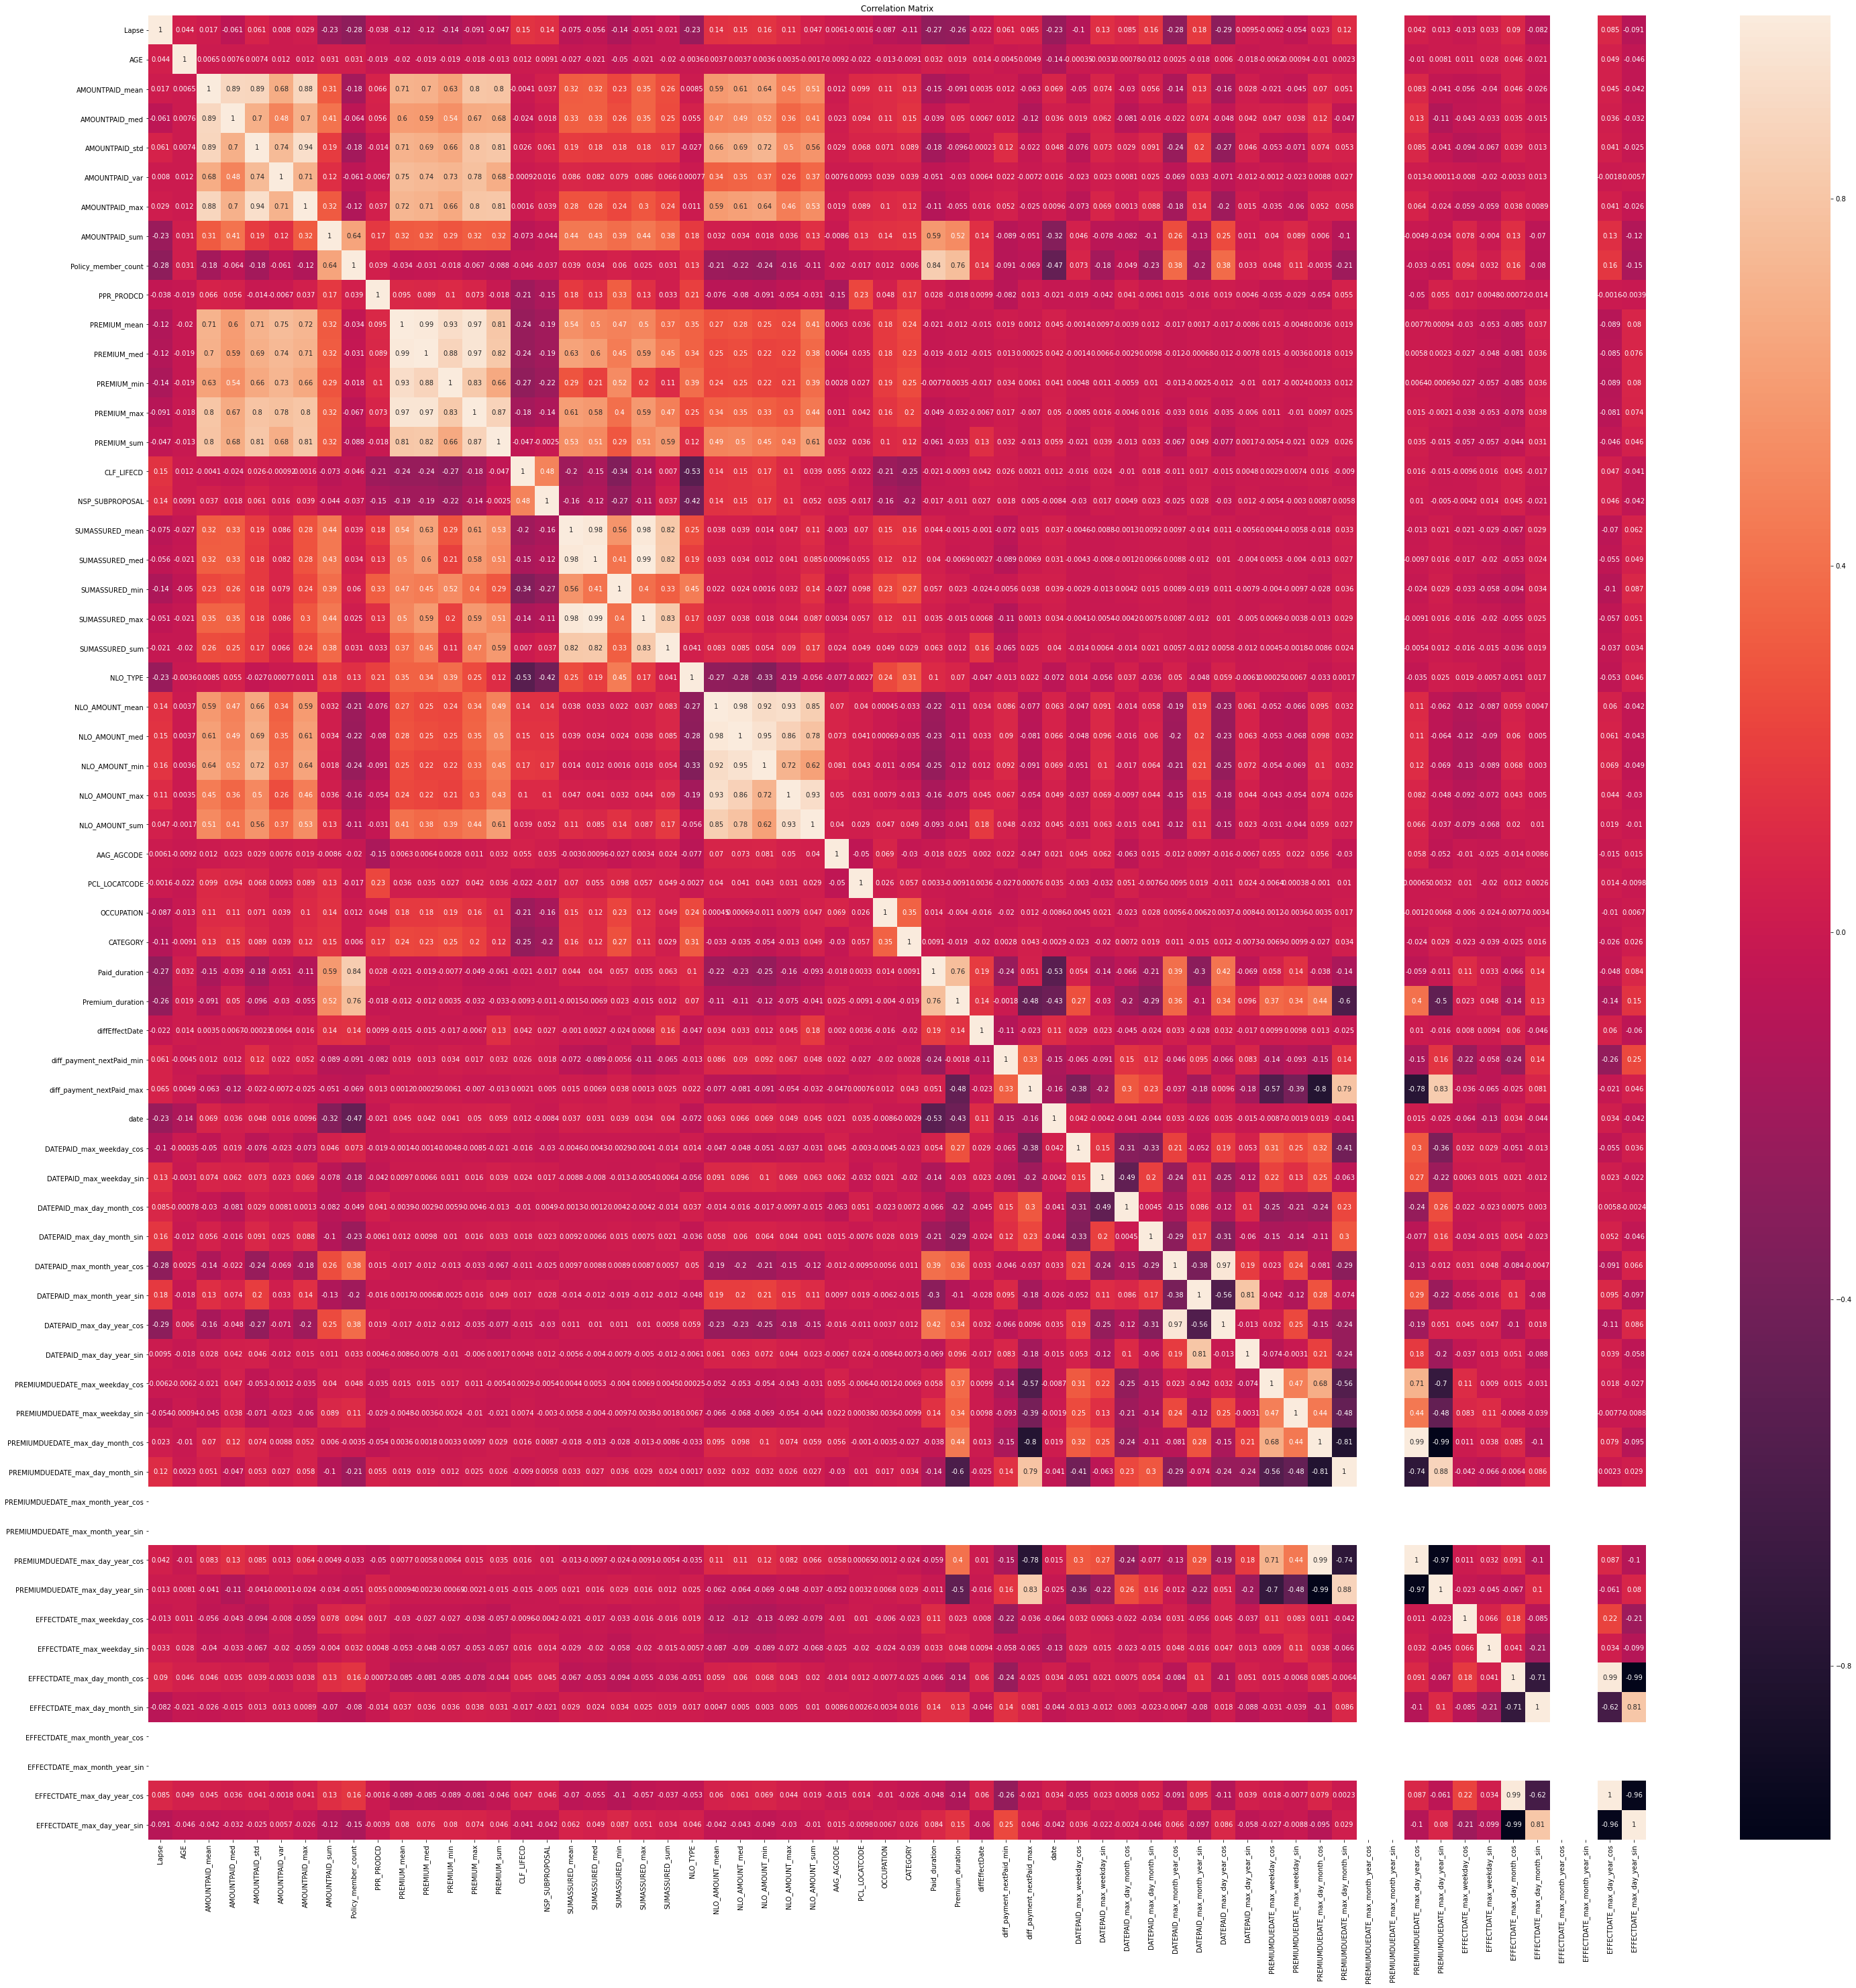

In [57]:
corr = all_train.corr()
plt.figure(figsize= (50, 50))
plt.title('Correlation Matrix')
sns.heatmap(corr, xticklabels= corr.columns, yticklabels= corr.columns, annot = True)
plt.show()

## Begin modif today

## Train model

In [59]:
features = [c for c in all_train.columns if c not in ['Policy ID', 'Lapse', 'Lapse Year', 'date', 'DATEPAID_min',
                                                      'DATEPAID_max', 'PREMIUMDUEDATE_min', 'PREMIUMDUEDATE_max',
                                                      'EFFECTDATE_min', 'EFFECTDATE_max']]

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR, SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
import xgboost as xgb
from sklearn.dummy import DummyClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,  VotingClassifier, BaggingClassifier
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler, EditedNearestNeighbours, TomekLinks, NearMiss
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, log_loss
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.utils import shuffle

Using TensorFlow backend.


In [127]:
corr_lapse = np.abs(corr.iloc[0])
features = [l for l in list(corr_lapse[corr_lapse>=0.1].index) if l not in ['Lapse', 'date']]
print(features)

['AMOUNTPAID_sum', 'Policy_member_count', 'PREMIUM_mean', 'PREMIUM_med', 'PREMIUM_min', 'CLF_LIFECD', 'NSP_SUBPROPOSAL', 'SUMASSURED_min', 'NLO_TYPE', 'NLO_AMOUNT_mean', 'NLO_AMOUNT_med', 'NLO_AMOUNT_min', 'NLO_AMOUNT_max', 'CATEGORY', 'Paid_duration', 'Premium_duration', 'DATEPAID_max_weekday_cos', 'DATEPAID_max_weekday_sin', 'DATEPAID_max_day_month_sin', 'DATEPAID_max_month_year_cos', 'DATEPAID_max_month_year_sin', 'DATEPAID_max_day_year_cos', 'PREMIUMDUEDATE_max_day_month_sin']


In [180]:
x_train = all_train[features].loc[(all_train['date']==2018) | (all_train['date']==2019)]
y_train = all_train['Lapse'].loc[(all_train['date']==2018) | (all_train['date']==2019)]

x_test = all_train[features].loc[(all_train['date']==2017)]
y_test = all_train['Lapse'].loc[(all_train['date']==2017)]

## OverSampling

In [172]:
smote = SMOTE('auto', 6)

In [181]:
x_train, y_train = smote.fit_sample(x_train, y_train)
x_train.shape, x_train.shape

((64626, 23), (64626, 23))

## Training Model

In [182]:
model = xgb.XGBClassifier(learning_rate= 0.1, max_depth= 8,  n_estimators= 100)

model.fit(x_train, y_train, eval_set= [(x_train, y_train), (x_test, y_test)], early_stopping_rounds= 200, verbose= 100)

y_train_pred = model.predict_proba(x_train)

y_test_pred = model.predict_proba(x_test)

print('log_loss train', log_loss(y_train, y_train_pred))
print('log_loss test', log_loss(y_test, y_test_pred))

[0]	validation_0-error:0.091124	validation_1-error:0.158279
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 200 rounds.
[99]	validation_0-error:0.041949	validation_1-error:0.159033
log_loss train 0.17389642891874663
log_loss test 0.3377826283344177


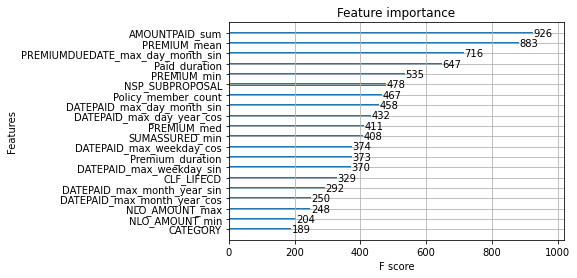

In [183]:
from xgboost import plot_importance, plot_tree
#from lightgbm import plot_importance

plot_importance(model, max_num_features= 20)

In [184]:
sub = pd.DataFrame()
sub['Policy ID'] = all_test['Policy ID']

In [185]:
temp = model.predict_proba(all_test[features])
temp = pd.DataFrame(temp)
temp.head()

,0,1
0,0.957831,0.042169
1,0.954015,0.045985
2,0.904887,0.095113
3,0.450855,0.549145
4,0.736687,0.263313


In [186]:
sub['Lapse'] = temp[1]
sub.head()

,Policy ID,Lapse
0,PID_4928TWH,0.042169
1,PID_KBLLEGK,0.045985
2,PID_90F0QA3,0.095113
3,PID_18F3NHF,0.549145
4,PID_SX4QUVO,0.263313


In [187]:
sub.to_csv('data/res/pred-xgb-3b.csv', index= False)

## top 20% for the final leaderboard